In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
data_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

In [9]:
batch_size = 32
img_height = 48
img_width = 48

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


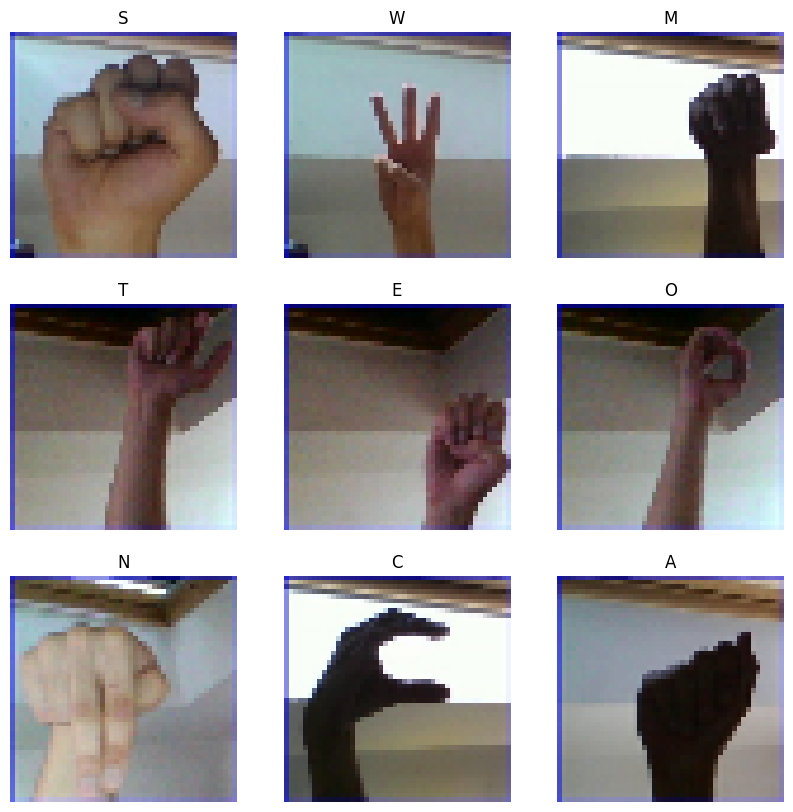

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0070261247 1.0


In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,365 (1.23 MB)

 Trainable params: 322,365 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1724942438.269677     134 service.cc:145] XLA service 0x7c340408fc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724942438.269741     134 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  14/2175 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.0497 - loss: 3.3796

I0000 00:00:1724942440.762326     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.5363 - loss: 1.5782 - val_accuracy: 0.9636 - val_loss: 0.1175
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9639 - loss: 0.1109 - val_accuracy: 0.9721 - val_loss: 0.0814
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9844 - loss: 0.0487 - val_accuracy: 0.9934 - val_loss: 0.0217
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9897 - loss: 0.0339 - val_accuracy: 0.9891 - val_loss: 0.0353
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9914 - loss: 0.0267 - val_accuracy: 0.9874 - val_loss: 0.0400
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9920 - loss: 0.0268 - val_accuracy: 0.9922 - val_loss: 0.0242
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9929 - loss: 0.0240 - val_accuracy: 0.9957 - val_loss: 0.0147
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9936 - loss: 0.0212 - val_accur

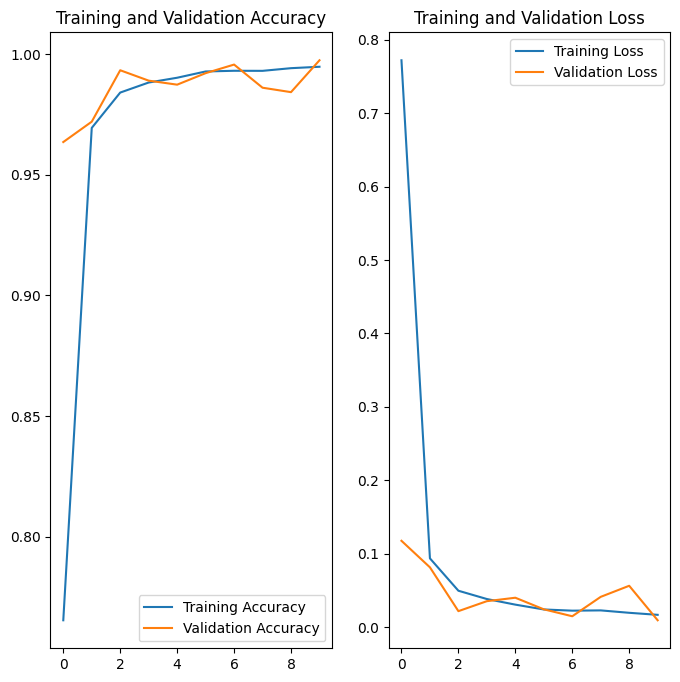

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

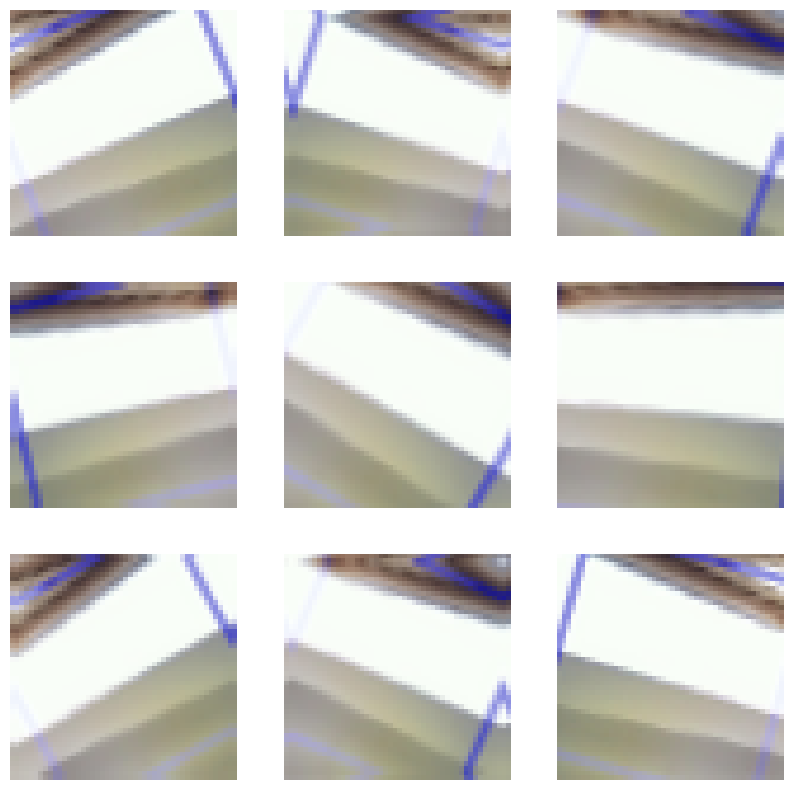

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [39]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
  10/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.0334 - loss: 3.3881   

2024-08-29 15:02:46.589229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2303 - loss: 2.6088 - val_accuracy: 0.6644 - val_loss: 1.0119
Epoch 2/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6472 - loss: 1.0571 - val_accuracy: 0.7418 - val_loss: 0.7294
Epoch 3/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7556 - loss: 0.7089 - val_accuracy: 0.8483 - val_loss: 0.4315
Epoch 4/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8157 - loss: 0.5315 - val_accuracy: 0.8644 - val_loss: 0.3812
Epoch 5/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8479 - loss: 0.4411 - val_accuracy: 0.9115 - val_loss: 0.2350
Epoch 6/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8736 - loss: 0.3612 - val_accuracy: 0.9005 - val_loss: 0.2728
Epoch 7/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8904 - loss: 0.3162 - val_accuracy: 0.9390 - val_loss: 0.1709
Epoch 8/15
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8999 - loss: 0.2856 - val

In [46]:
#model.save_weights("my_model.weights.h5")
#model.load_weights("my_model.weights.h5")
#model.save('test.keras')

In [ ]:
#import tensorflow as tf
#from tensorflow.keras.models import load_model

#model = tf.keras.models.load_model('/content/test.keras')

In [30]:
import os
import tensorflow as tf
import numpy as np

A_test = os.path.join('/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test', 'A_test.jpg')

img = tf.keras.utils.load_img(
    A_test, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
This image most likely belongs to A with a 99.16 percent confidence.
